<h1>Automated correction factors calculation from smFRET data</h1>

This notebook contains scripts to automatically calculate the correction factors for TIRF-based smFRET data and apply those corrections to the dataset

In [1]:
#Import necessary packages
import xarray as xr             #For data retrieval and processing
import matplotlib.pyplot as plt #For plotting
import numpy as np              #For processing arrays
import glob, os                 #For folder search
import matplotlib
from sklearn import mixture     #For 2D Gaussian fit


In [3]:
def total_mean_int(root_path, frames=[0,13]):
    # root_path = r'E:\Data\02 FRETFluc\20230217_138p_7N_3N_R1P_Cy3_Fluo\ch_138p_R1P_Cy3_500ms'
    nc_list = glob.glob(root_path )
    fr1,fr2 = frames    #Number of frames to extract
    ds = []             #Array to store individual .nc datasets (necessary??)
    donor_intensity = []    #Array to store donor intensities from datasets
    acceptor_intensity = [] #Array to store acceptor intensities from datasets
    #acceptor_excitation = []    #Array to store acceptor intensities (from acceptor excitation) from datasets (not used currently)

    #Loop through all .nc files and extract donor and acceptor intensities
    for fname in nc_list:
        nc_fname = os.path.join(root_path, fname)
        # nc_fname = os.path.join(root_path, f'*.nc')
        print(nc_fname)
        tmp_ds = xr.load_dataset(nc_fname, engine='h5netcdf')
        ds.append(tmp_ds)
        donor_intensity.append(tmp_ds.intensity[:,0].isel(frame=slice(fr1,fr2)).mean("frame"))
        acceptor_intensity.append(tmp_ds.intensity[:,1].isel(frame=slice(fr1,fr2)).mean("frame"))
        # acceptor_excitation.append(tmp_ds.intensity[:,1,1::2].isel(frame=slice(fr1,fr2)).mean("frame"))

    d_int = []
    a_int = []
    # a_exc = []
    #Rewrite this part using numpy's function -- flattening the array
    for i in range(len(donor_intensity)):
        d_int = np.concatenate((donor_intensity[i],d_int))
        a_int = np.concatenate((acceptor_intensity[i],a_int))
        # a_exc = np.concatenate((acceptor_excitation[i],a_exc))
    return d_int, a_int

N:\tnw\BN\Shared\Archana_N\Microscopy TIR-S\20230511 ssRNA Trial 2\Casimer project data set\ch001_fov000.nc
N:\tnw\BN\Shared\Archana_N\Microscopy TIR-S\20230511 ssRNA Trial 2\Casimer project data set\ch001_fov001.nc
N:\tnw\BN\Shared\Archana_N\Microscopy TIR-S\20230511 ssRNA Trial 2\Casimer project data set\ch001_fov002.nc
N:\tnw\BN\Shared\Archana_N\Microscopy TIR-S\20230511 ssRNA Trial 2\Casimer project data set\ch001_fov003.nc
N:\tnw\BN\Shared\Archana_N\Microscopy TIR-S\20230511 ssRNA Trial 2\Casimer project data set\ch001_fov004.nc
N:\tnw\BN\Shared\Archana_N\Microscopy TIR-S\20230511 ssRNA Trial 2\Casimer project data set\ch001_fov005.nc
N:\tnw\BN\Shared\Archana_N\Microscopy TIR-S\20230511 ssRNA Trial 2\Casimer project data set\ch001_fov006.nc
N:\tnw\BN\Shared\Archana_N\Microscopy TIR-S\20230511 ssRNA Trial 2\Casimer project data set\ch001_fov007.nc
N:\tnw\BN\Shared\Archana_N\Microscopy TIR-S\20230511 ssRNA Trial 2\Casimer project data set\ch001_fov008.nc


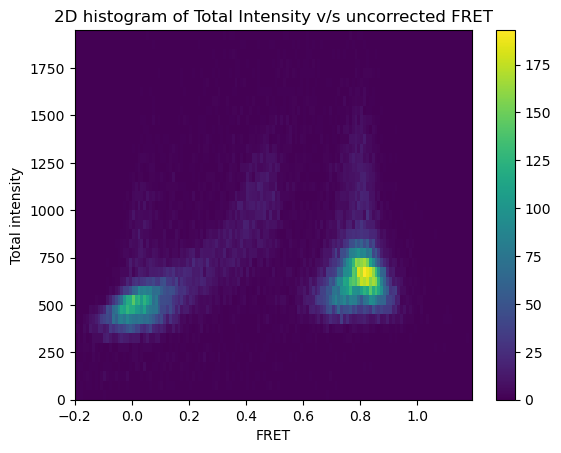

In [12]:

#Import folder with .nc files (excluding background correction files)
donor_int, acceptor_int = total_mean_int(r'N:\tnw\BN\Shared\Archana_N\Microscopy TIR-S\20230511 ssRNA Trial 2\Casimer project data set\*.nc')

# donor_int, acceptor_int = total_mean_int(r'C:\Experiments\00 Data\02 FRETFluc\20230621_Cy3_Cy5_test_PCRed_sample\TIR-S\ch02_new_PCRed_sample\*[!corrections].nc')

#Bins for intensity and FRET efficiency
bins_i = np.arange(0, 2000, 50)     #For TIR-S, 0-2000 is reasonable -- change it for other microscopes
bins_f = np.arange(-0.2,1.2,0.01)   #FRET efficiency spanning 0 to 1, but padded by 0.2 on either end

#Calculate total intensity and FRET efficiency for the dataset
total_intensity = donor_int + acceptor_int
fret = acceptor_int / (total_intensity)

#Plot 2D-histogram of Total Intensity v/s FRET Efficiency
plt.hist2d(fret, total_intensity, bins=[bins_f,bins_i])
plt.title('2D histogram of Total Intensity v/s uncorrected FRET')
plt.xlabel('FRET')
plt.ylabel('Total intensity')
plt.colorbar()
plt.show()

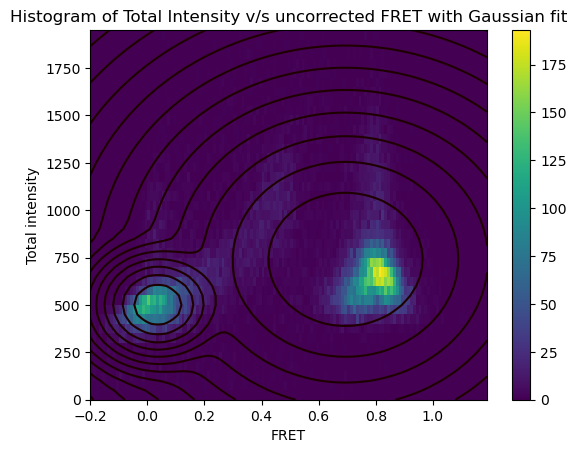

In [11]:
# Plot 2D-histogram of Total Intensity v/s FRET Efficiency
plt.hist2d(fret, total_intensity, bins=[bins_f, bins_i])
plt.title('Histogram of Total Intensity v/s uncorrected FRET with Gaussian fit')
plt.xlabel('FRET')
plt.ylabel('Total intensity')
plt.colorbar()

#Define Gaussian Mixuture model with 3 components
clf = mixture.GaussianMixture(n_components=2, covariance_type="diag", init_params='k-means++', means_init=[[0.2,500], [0.7,500]])
X_train = np.vstack((fret, total_intensity)).T
params = clf.fit(X_train)

#Plot contour of the two 2D Gaussians on the same plot
X, Y = np.meshgrid(bins_f, bins_i)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)
CS = plt.contour(X, Y, Z, levels=np.logspace(0, 50, 1000), cmap='pink')

# Extract the mean1 and mean2 Intensity values from the fitted parameters
all_mean1, all_mean2 = clf.means_
mean1 = all_mean1[1]
mean2 = all_mean2[1]

plt.show()



Current Gamma iteration:  1.0
Current Gamma iteration:  1.01
Current Gamma iteration:  1.02
Current Gamma iteration:  1.03
Current Gamma iteration:  1.04
Current Gamma iteration:  1.05
Current Gamma iteration:  1.06
Current Gamma iteration:  1.07
Current Gamma iteration:  1.08
Current Gamma iteration:  1.09
Current Gamma iteration:  1.1
Current Gamma iteration:  1.11
Current Gamma iteration:  1.12
Current Gamma iteration:  1.1300000000000001
Current Gamma iteration:  1.1400000000000001
Current Gamma iteration:  1.1500000000000001
Current Gamma iteration:  1.1600000000000001
Current Gamma iteration:  1.1700000000000002
Current Gamma iteration:  1.1800000000000002
Current Gamma iteration:  1.1900000000000002
Current Gamma iteration:  1.2000000000000002
Current Gamma iteration:  1.2100000000000002
Current Gamma iteration:  1.2200000000000002
Current Gamma iteration:  1.2300000000000002
Current Gamma iteration:  1.2400000000000002
Current Gamma iteration:  1.2500000000000002
Current Gamma 

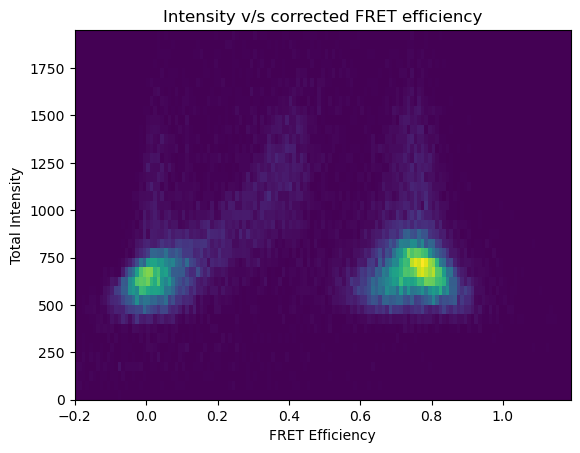

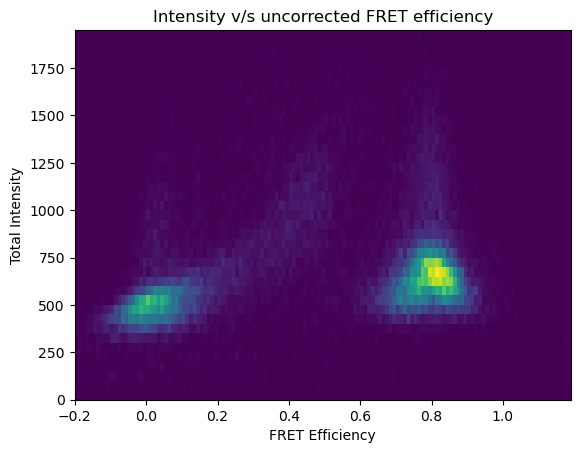

In [6]:
#Define Root-square error between the two mean intensities
Ierror = np.sqrt(np.power((mean2-mean1),2))

for gamma in np.arange(1,2.5,0.01):
    print("Current Gamma iteration: ", gamma)

    #Correct donor intensities with the correction factor(gamma) and calculate updated intensities and FRET
    d_intCorrected = donor_int*gamma
    total_intensityC = d_intCorrected + acceptor_int
    fretC = acceptor_int / (total_intensityC)
    
    #Calculate histogram with updated values
    hist, x_edges, y_edges = np.histogram2d(fretC, total_intensityC, bins=[bins_f, bins_i])
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    X, Y = np.meshgrid(x_centers, y_centers)
    xy = np.vstack((X.ravel(), Y.ravel()))

    # Gaussian fit with updated values
    clf = mixture.GaussianMixture(n_components=2, covariance_type="diag", init_params='k-means++', means_init=[[0.2,500], [0.7,500]])
    X_train = np.vstack((fretC, total_intensityC)).T
    params = clf.fit(X_train)

    # Extract the mean1 and mean2 values from the fitted parameters
    all_mean1, all_mean2 = clf.means_
    meanC1 = all_mean1[1]
    meanC2 = all_mean2[1]
    
    IerrorC = np.sqrt(np.power((meanC2-meanC1),2))

    #Check the updated root-square error before trying the next value
    #This method only checks for local minima and not the global one (TODO)
    if IerrorC < Ierror:
       continue
    else: 
       break

#Plot before and after corrections
plt.hist2d(fretC, total_intensityC, bins=[bins_f, bins_i])
plt.colorbar()
plt.xlabel('FRET Efficiency')
plt.ylabel('Total Intensity')
plt.title('Intensity v/s corrected FRET efficiency')


plt.figure()
plt.hist2d(fret, total_intensity, bins=[bins_f, bins_i])
plt.colorbar()
plt.xlabel('FRET Efficiency')
plt.ylabel('Total Intensity')
plt.title('Intensity v/s uncorrected FRET efficiency')


#Print all factors
print("Gamma : ", gamma)
print("Ierror : ", Ierror)
print("IerrorC : ", IerrorC)
print("Mean C1 : ", meanC1)
print("Mean C2 : ", meanC2)
    